In [1]:
# set path to parent file
from pathlib import Path
import os
cwd_path = Path.cwd()
set_path = str(cwd_path.parent)
os.chdir(set_path)

In [2]:
from Utils import running_mean, multiple_runs_with_different_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
import SimulatedAnealing 
importlib.reload(SimulatedAnealing)
SimulatedAnnealing = SimulatedAnealing.SimulatedAnnealing
mpl.rcParams['figure.dpi'] = 300
from rana import rana_func


In [3]:
import itertools
n = 500
x_linspace = np.linspace(-500, 500, n)
x = np.array(list(itertools.product(x_linspace, repeat=2))) 
objectives = np.apply_along_axis(func1d=rana_func, arr=x , axis=1)
x1 = x[:, 0].reshape(n, n)
x2 = x[:, 1].reshape(500, 500)
z = objectives.reshape(500, 500)

# What do we want?
    - comparison of results for various configurations
    - basis diagram with basic search
    - 2D diagram all search patters


# Simple Plot

In [4]:
configuration = {"pertubation_method": "simple",
                     "x_length": 2,
                     "x_bounds": (-500, 500),
                     "annealing_schedule":"simple_exponential_cooling",
                     "objective_function": rana_func,
                     "maximum_archive_length": 100,
                     "archive_minimum_acceptable_dissimilarity": 0.2,
                     "maximum_markov_chain_length": 50,
                     "maximum_function_evaluations": 10000,
                     "step_size_initialisation_fraction_of_range": 0.1,
                     "bound_enforcing_method": "not_clipping",
                     "cholesky_path_length": 5,
                    }
np.random.seed(3)
rana_2d_chol = SimulatedAnnealing(**configuration)
x_result_chol, objective_result_chol = rana_2d_chol.run()
print(f"x_result = {x_result_chol} \n objective_result = {objective_result_chol} \n "
      f"number of function evaluations = {rana_2d_chol.objective_function_evaluation_count}")
print(f"best objective result {rana_2d_chol.objective_history_array.min()}")

converged
x_result = [234.52919913 481.37989127] 
 objective_result = -480.25080611610315 
 number of function evaluations = 8000
best objective result -489.5734366137921


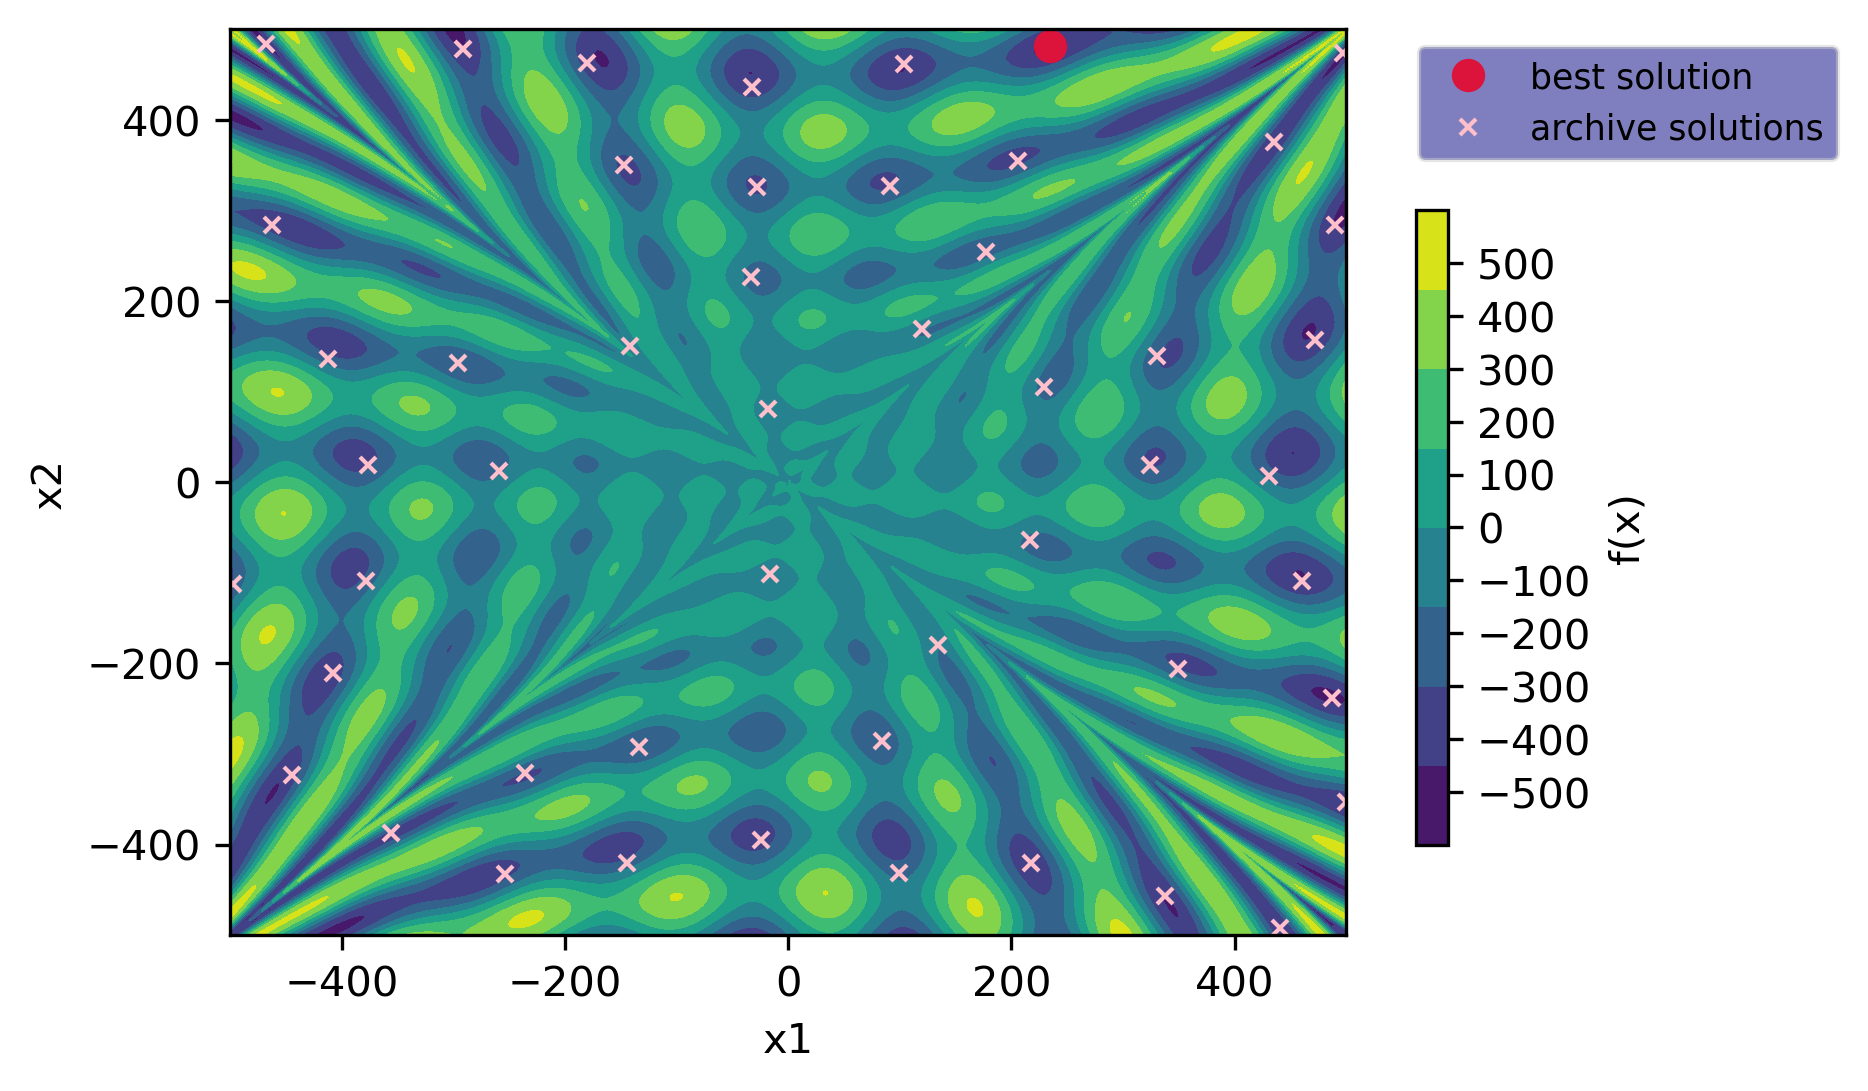

In [5]:
fig, ax = plt.subplots()
plot_list = []
cs = ax.contourf(x1,x2,z)
CB = fig.colorbar(cs, label="f(x)")
CB.set_ticks(np.linspace(-500, 500, 11))
rana_2d_chol.clean_archive()
p1, = ax.plot(rana_2d_chol.archive_x[:, 0], rana_2d_chol.archive_x[:, 1], "xr", 
             markersize=4, label="archive solutions", color="pink")
p2, = ax.plot(x_result_chol[0], x_result_chol[1], 
             'o', ms=7, color="crimson",
             label="best solution")
plot_list.append(p2); plot_list.append(p1)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(handles=plot_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', facecolor='navy', framealpha=0.5)
l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b + 0.1*h, ww, h*0.7])

fig.savefig("./Figures/SE2D_2D_archive.png", bbox_inches = 'tight',pad_inches = 0)

<ipython-input-6-752c528d5adc>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


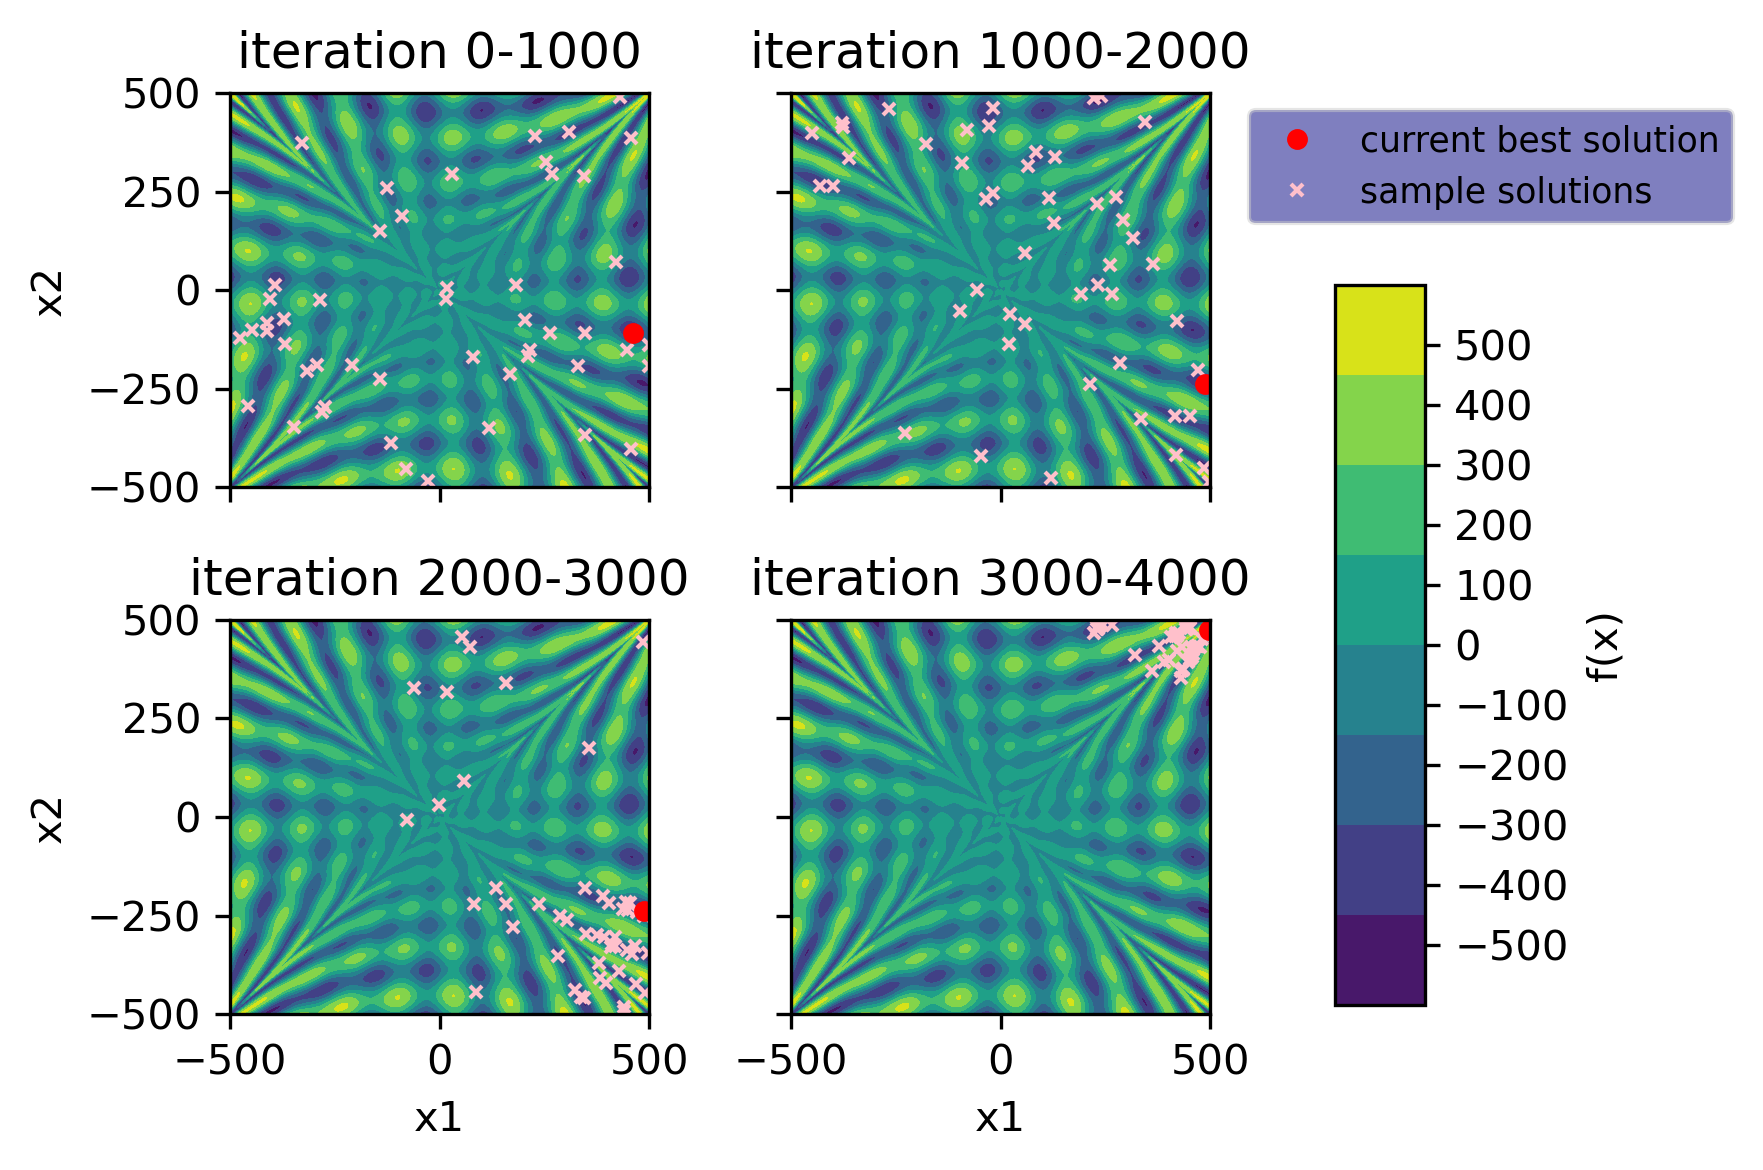

In [6]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_list = []
dist = 1000
length =  rana_2d_chol.accepted_objective_history_array.shape[0]
positions = np.linspace(0, dist*3, 4, dtype="int")
n_points = 50
for i in range(4):
    minimum_so_far = rana_2d_chol.x_history_array[np.argmin(rana_2d_chol.objective_history_array[:positions[i]+dist]), :]
    row = int(i/2)
    col = i % 2 
    #indxs = np.linspace(positions[i], positions[i]+dist, 50, dtype="int")
    #x_data = rana_2d_chol.x_history_array[indxs, :]
    all_indxs = np.arange(length)[(rana_2d_chol.accepted_objective_history_array[:, 1] > positions[i]) & 
                              (rana_2d_chol.accepted_objective_history_array[:, 1] < positions[i]+dist)] 
    indxs = np.random.choice(all_indxs, replace=False, size = min(n_points, len(all_indxs)))
    x_data = rana_2d_chol.accepted_x_history_array[indxs, :]
    cs = ax[row, col].contourf(x1,x2,z)
    p2, = ax[row, col].plot(x_data[:, 0], x_data[:, 1], "x", color="pink", markersize=3, label="sample solutions")
    p1, = ax[row, col].plot(minimum_so_far[0], minimum_so_far[1], "or", label="current best solution", markersize=4)
    ax[row, col].set_title(f"iteration {positions[i]}-{positions[i]+dist}")
    

plot_list.append(p1)
plot_list.append(p2)
ax[0, 1].legend(handles=plot_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', facecolor='navy', framealpha=0.5)    


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.6])
CB = fig.colorbar(cs, label="f(x)", cax=cbar_ax)
CB.set_ticks(np.linspace(-500, 500, 11))

ax[1, 1].set_xlabel("x1")
ax[1, 0].set_xlabel("x1")
ax[0, 0].set_ylabel("x2")
ax[1, 0].set_ylabel("x2")
fig.tight_layout()


fig.savefig("./Figures/SE2D_2D_progress_contour_SIMPLE.png", bbox_inches = 'tight',pad_inches = 0)

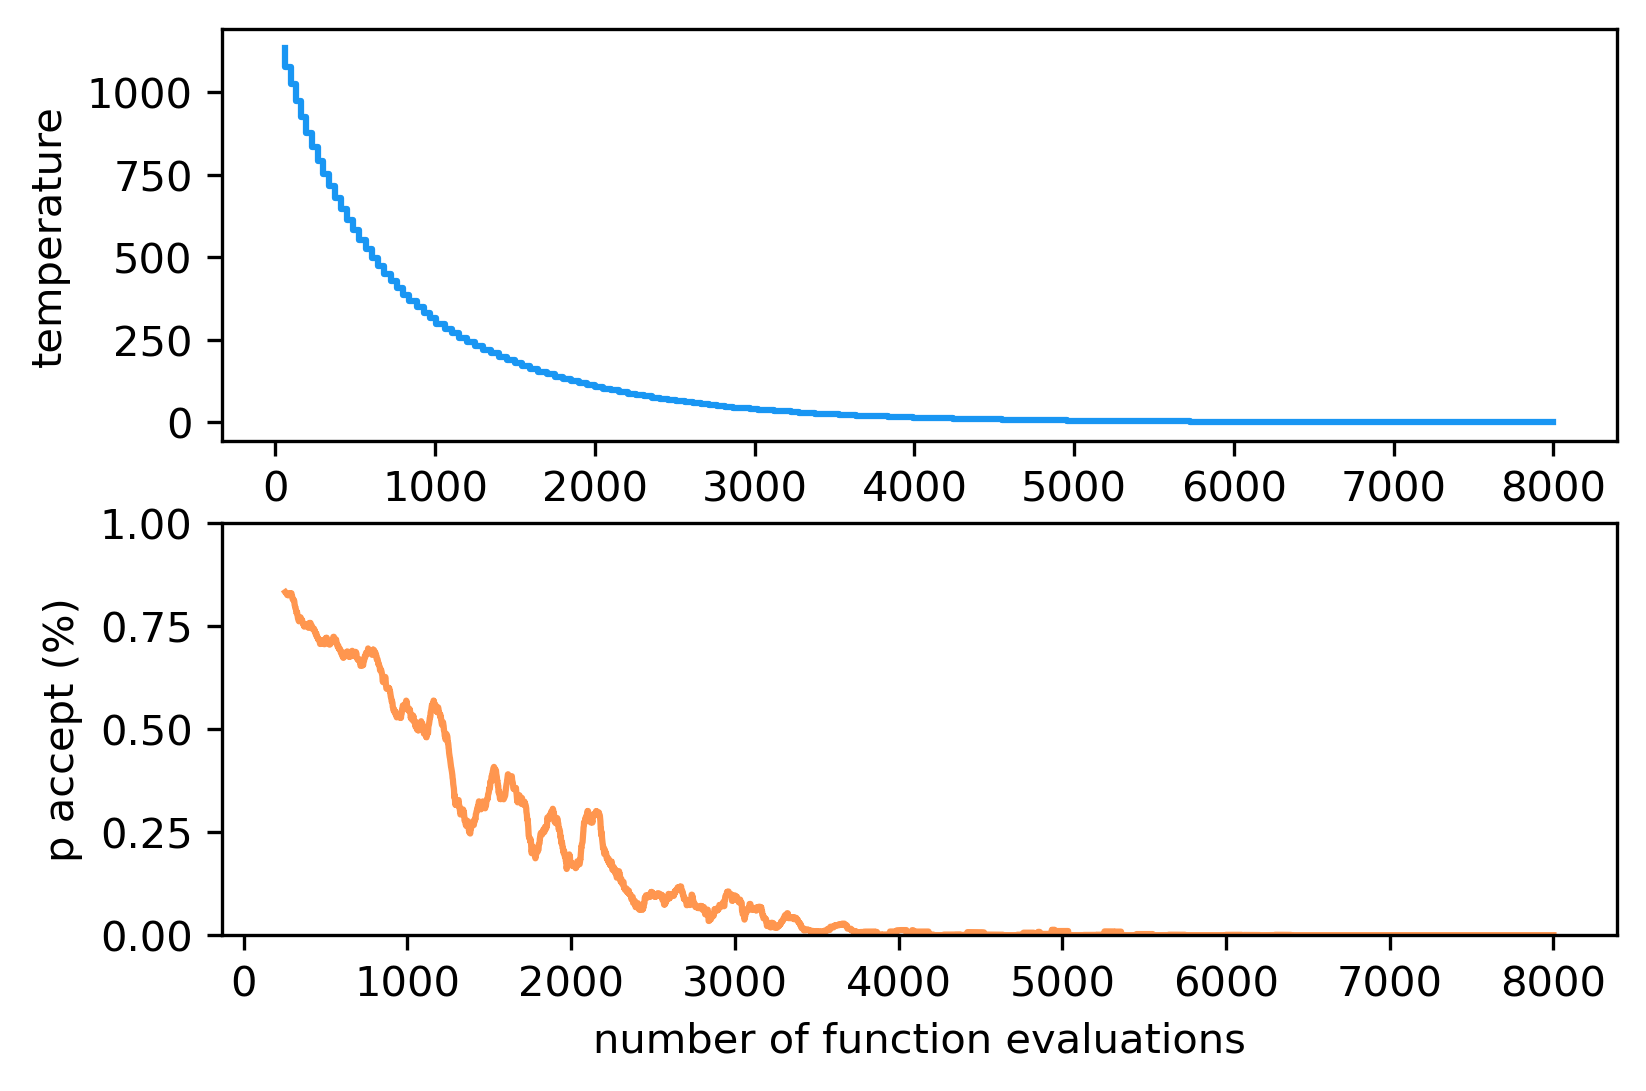

In [8]:
fig, axs = plt.subplots(2,1)
cols = mpl.cm.rainbow(np.linspace(0.2,0.8,3))

axs[0].step(rana_2d_chol.temperature_history_array[:, 2], rana_2d_chol.temperature_history_array[:, 0], color=cols [0])
axs[0].set_yticks(np.linspace(0, np.around(rana_2d_chol.temperature_history_array[:, 0].max(), -3), 5))
p_accept_running_mean = running_mean(rana_2d_chol.probability_of_acceptance_history_array[:, 0], 100)
axs[1].plot(rana_2d_chol.probability_of_acceptance_history_array[-len(p_accept_running_mean):, 1], p_accept_running_mean
           , color=cols [2])
axs[1].set_ylim(0,1)
axs[0].set_ylabel("temperature")
axs[1].set_ylabel("p accept (%)")
axs[1].set_xlabel("number of function evaluations")
fig.savefig("./Figures/SE2D_temp_prob.png", bbox_inches = 'tight',pad_inches = 0)

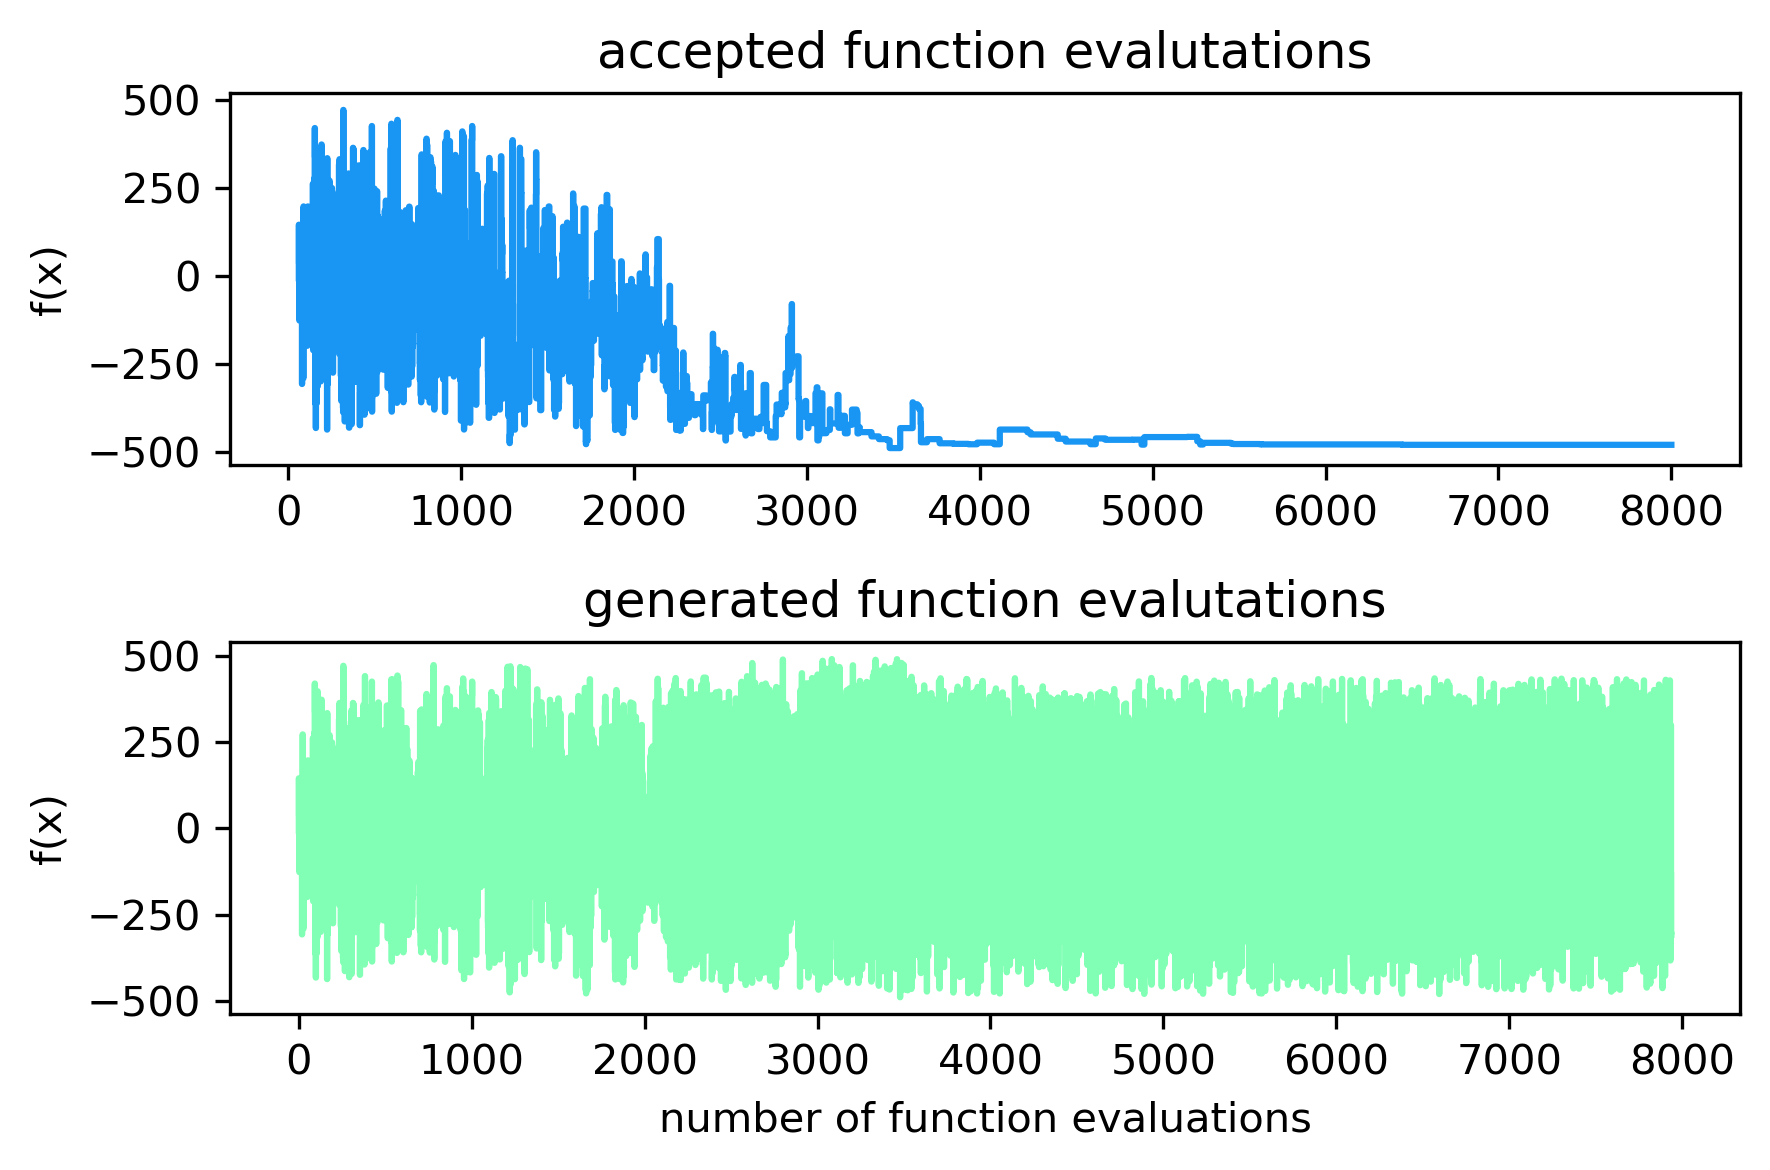

In [9]:
fig, axs = plt.subplots(2,1)
cols = mpl.cm.rainbow(np.linspace(0.2,0.8,3))
axs[0].step(rana_2d_chol.accepted_objective_history_array[:, 1], rana_2d_chol.accepted_objective_history_array[:, 0], color=cols[0])
axs[1].step(np.arange(len(rana_2d_chol.objective_history_array)), rana_2d_chol.objective_history_array, color=cols[1])
axs[0].set_yticks(np.linspace(-500, 500, 5))
axs[0].set_title("accepted function evalutations")
axs[0].set_ylabel("f(x)")

axs[1].set_yticks(np.linspace(-500, 500, 5))

axs[1].set_title("generated function evalutations")
axs[1].set_ylabel("f(x)")
axs[1].set_xlabel("number of function evaluations")

fig.tight_layout()
fig.savefig("./Figures/SE2D_func_eval_hist.png", bbox_inches = 'tight',pad_inches = 0)

# Plots Cholseky

In [14]:
configuration = {"pertubation_method": "Cholesky",
                     "x_length": 2,
                     "x_bounds": (-500, 500),
                     "annealing_schedule":"simple_exponential_cooling",
                     "objective_function": rana_func,
                     "maximum_archive_length": 100,
                     "archive_minimum_acceptable_dissimilarity": 0.2,
                     "maximum_markov_chain_length": 50,
                     "maximum_function_evaluations": 10000,
                     "step_size_initialisation_fraction_of_range": 0.05,
                     "bound_enforcing_method": "not_clipping",
                     "cholesky_path_length": 5,
                    }

In [15]:
np.random.seed(0)
rana_2d_chol = SimulatedAnnealing(**configuration)
x_result_chol, objective_result_chol = rana_2d_chol.run()
print(f"x_result = {x_result_chol} \n objective_result = {objective_result_chol} \n "
      f"number of function evaluations = {rana_2d_chol.objective_function_evaluation_count}")
print(f"best objective result {rana_2d_chol.objective_history_array.min()}")

x_result = [499.99932272 475.17267989] 
 objective_result = -499.3105277144771 
 number of function evaluations = 10000
best objective result -499.3271990076007


Text(0, 0.5, 'p accept (%)')

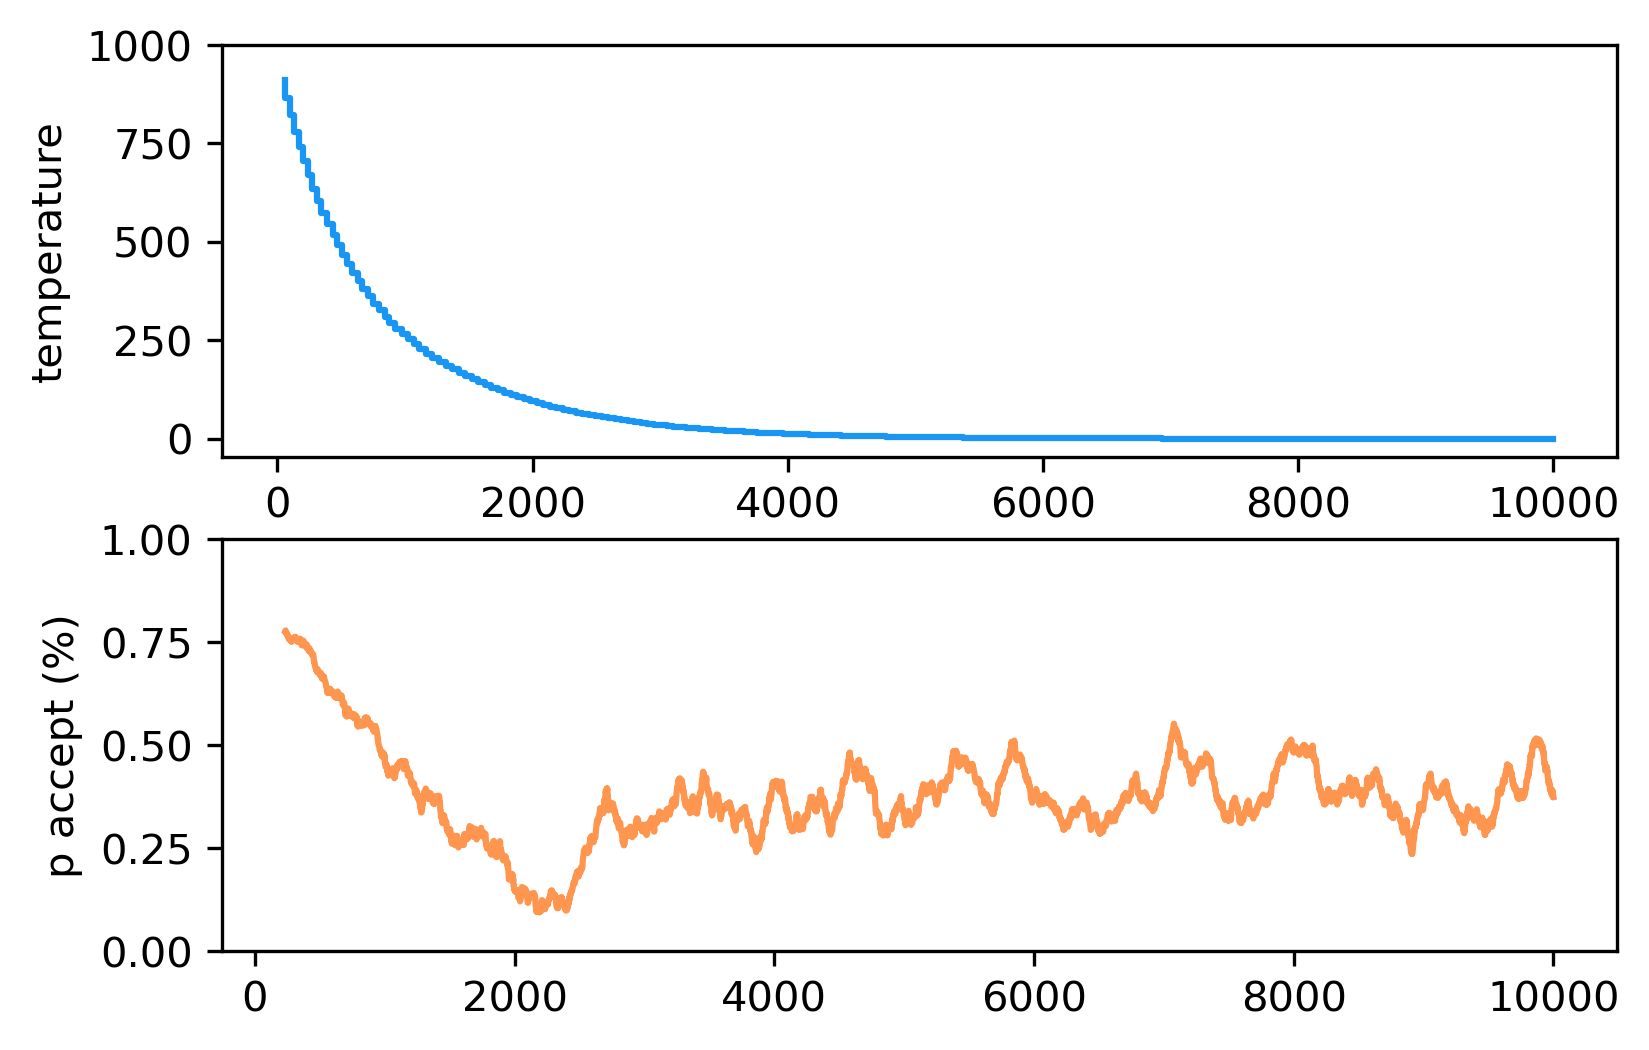

In [16]:
fig, axs = plt.subplots(2,1)
cols = mpl.cm.rainbow(np.linspace(0.2,0.8,3))

axs[0].step(rana_2d_chol.temperature_history_array[:, 2], rana_2d_chol.temperature_history_array[:, 0], color=cols [0])
axs[0].set_yticks(np.linspace(0, np.around(rana_2d_chol.temperature_history_array[:, 0].max(), -3), 5))
p_accept_running_mean = running_mean(rana_2d_chol.probability_of_acceptance_history_array[:, 0], 100)
axs[1].plot(rana_2d_chol.probability_of_acceptance_history_array[-len(p_accept_running_mean):, 1], p_accept_running_mean
           , color=cols [2])
axs[1].set_ylim(0,1)
axs[0].set_ylabel("temperature")
axs[1].set_ylabel("p accept (%)")
#fig.savefig("./Figures/SE2D_temp_prob.png")

<ipython-input-17-ff79c21ee248>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


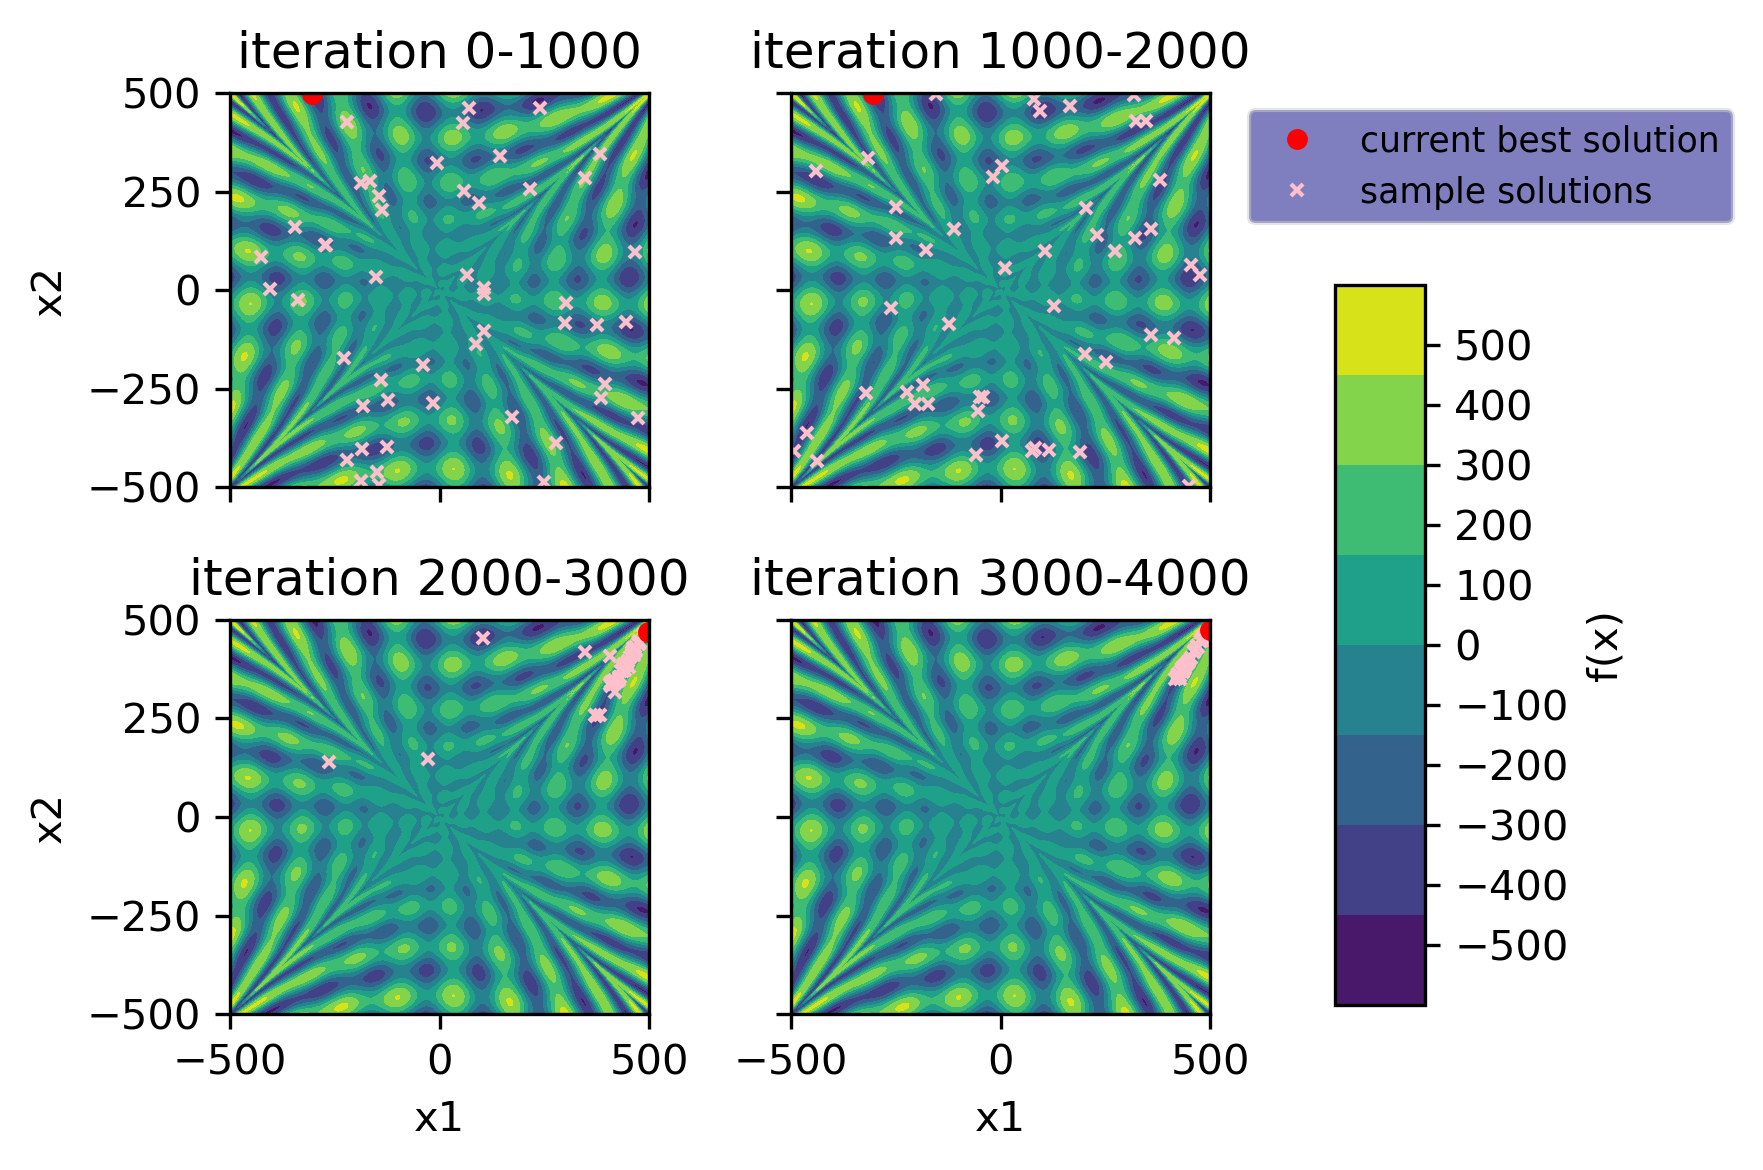

In [17]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_list = []
dist = 1000
length =  rana_2d_chol.accepted_objective_history_array.shape[0]
positions = np.linspace(0, dist*3, 4, dtype="int")
n_points = 50
for i in range(4):
    minimum_so_far = rana_2d_chol.x_history_array[np.argmin(rana_2d_chol.objective_history_array[:positions[i]+dist]), :]
    row = int(i/2)
    col = i % 2 
    #indxs = np.linspace(positions[i], positions[i]+dist, 50, dtype="int")
    #x_data = rana_2d_chol.x_history_array[indxs, :]
    all_indxs = np.arange(length)[(rana_2d_chol.accepted_objective_history_array[:, 1] > positions[i]) & 
                              (rana_2d_chol.accepted_objective_history_array[:, 1] < positions[i]+dist)] 
    indxs = np.random.choice(all_indxs, replace=False, size = min(n_points, len(all_indxs)))
    x_data = rana_2d_chol.accepted_x_history_array[indxs, :]
    cs = ax[row, col].contourf(x1,x2,z)
    p2, = ax[row, col].plot(x_data[:, 0], x_data[:, 1], "x", color="pink", markersize=3, label="sample solutions")
    p1, = ax[row, col].plot(minimum_so_far[0], minimum_so_far[1], "or", label="current best solution", markersize=4)
    ax[row, col].set_title(f"iteration {positions[i]}-{positions[i]+dist}")
    

plot_list.append(p1)
plot_list.append(p2)
ax[0, 1].legend(handles=plot_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', facecolor='navy', framealpha=0.5)    


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.6])
CB = fig.colorbar(cs, label="f(x)", cax=cbar_ax)
CB.set_ticks(np.linspace(-500, 500, 11))

ax[1, 1].set_xlabel("x1")
ax[1, 0].set_xlabel("x1")
ax[0, 0].set_ylabel("x2")
ax[1, 0].set_ylabel("x2")
fig.tight_layout()


fig.savefig("./Figures/SE2D_2D_progress_contour_Chol.png", bbox_inches = 'tight',pad_inches = 0)

In [ ]:
fig, axs = plt.subplots(3,1)
cols = mpl.cm.rainbow(np.linspace(0.2,0.8,3))
axs[0].step(rana_2d_chol.accepted_objective_history_array[:, 1], rana_2d_chol.accepted_objective_history_array[:, 0], color=cols[0])
axs[1].step(np.arange(len(rana_2d_chol.objective_history_array)), rana_2d_chol.objective_history_array, color=cols[1])
axs[2].step(np.arange(len(np.linalg.det(rana_2d_chol.step_size_matrix_history_array))),
                      np.linalg.det(rana_2d_chol.step_size_matrix_history_array), color=cols[2])

axs[0].set_yticks(np.linspace(-500, 500, 5))
axs[0].set_title("accepted function evalutation")
axs[0].set_ylabel("f(x)")


axs[1].set_yticks(np.linspace(-500, 500, 5))
axs[1].set_title("complete function evalutation")
axs[1].set_ylabel("f(x)")


axs[2].set_title("Determinant of step size matrix")
axs[2].set_ylabel("det(M)")
axs[2].set_xlabel("number of function evalutations")
axs[2].set_yscale("log")
axs[2].set_yticks([1e-4,1e-8, 1])


fig.tight_layout()
#fig.savefig("./Figures/SE2D_func_eval_hist.png")

# Contour plots

In [ ]:
"""
n = 500
x1_linspace = np.linspace(-500, 500, n)
x2_linspace = np.linspace(-500, 500, n)
z = np.zeros((n, n))
for i, x1_val in enumerate(x1_linspace):
    for j, x2_val in enumerate(x2_linspace):
        z[i, j] = rana_func(np.array([x1_val, x2_val]))
x2, x1 = np.meshgrid(x1_linspace, x2_linspace)
"""
import itertools
n = 500
x_linspace = np.linspace(-500, 500, n)
x = np.array(list(itertools.product(x_linspace, repeat=2))) 
objectives = np.apply_along_axis(func1d=rana_func, arr=x , axis=1)
x1 = x[:, 0].reshape(n, n)
x2 = x[:, 1].reshape(500, 500)
z = objectives.reshape(500, 500)

In [ ]:
fig, ax = plt.subplots()
plot_list = []
cs = ax.contourf(x1,x2,z)
CB = fig.colorbar(cs, label="f(x)")
CB.set_ticks(np.linspace(-500, 500, 11))
p1, = ax.plot(rana_2d_chol.archive_x[:, 0], rana_2d_chol.archive_x[:, 1], "xr", 
             markersize=4, label="archive solutions", color="pink")
p2, = ax.plot(x_result_chol[0], x_result_chol[1], 
             'o', ms=7, color="crimson",
             label="best solution")
plot_list.append(p2); plot_list.append(p1)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(handles=plot_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', facecolor='navy', framealpha=0.5)
l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b + 0.1*h, ww, h*0.7])

#fig.savefig("./Figures/SE2D_2D_archive_CHOL.png")

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_list = []
positions = [0, 1500, 3000, 4500]
n_points = 20
for i in range(4):
    minimum_so_far = rana_2d_chol.x_history_array[np.argmin(rana_2d_chol.objective_history_array[:positions[i]+n_points]), :]
    row = int(i/2)
    col = i % 2 
    indxs = np.linspace(positions[i], positions[i]+1500, 50, dtype="int")
    x_data = rana_2d_chol.x_history_array[indxs, :]
    cs = ax[row, col].contourf(x1,x2,z)
    p2, = ax[row, col].plot(x_data[:, 0], x_data[:, 1], "x", color="pink", markersize=3, label="sample solutions")
    p1, = ax[row, col].plot(minimum_so_far[0], minimum_so_far[1], "or", label="current best solution", markersize=4)
    ax[row, col].set_title(f"iteration {positions[i]}-{positions[i]+1500}")
    

plot_list.append(p1)
plot_list.append(p2)
ax[0, 1].legend(handles=plot_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', facecolor='navy', framealpha=0.5)    


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.6])
CB = fig.colorbar(cs, label="f(x)", cax=cbar_ax)
CB.set_ticks(np.linspace(-500, 500, 11))

ax[1, 1].set_xlabel("x1")
ax[1, 0].set_xlabel("x1")
ax[0, 0].set_ylabel("x2")
ax[1, 0].set_ylabel("x2")
fig.tight_layout()


#fig.savefig("./Figures/SE2D_2D_progress_contour.png")

# Diagonal Plot

In [ ]:
configuration = {"pertubation_method": "Diagonal",
                     "x_length": 2,
                     "x_bounds": (-500, 500),
                     "annealing_schedule":"simple_exponential_cooling",
                     "objective_function": rana_func,
                     "maximum_archive_length": 100,
                     "archive_minimum_acceptable_dissimilarity": 0.2,
                     "maximum_markov_chain_length": 50,
                     "maximum_function_evaluations": 10000,
                     "step_size_initialisation_fraction_of_range": 0.1,
                     "bound_enforcing_method": "not_clipping",
                     "cholesky_path_length": 5,
                    }
np.random.seed(0)
rana_2d_chol = SimulatedAnnealing(**configuration)
x_result_chol, objective_result_chol = rana_2d_chol.run()
print(f"x_result = {x_result_chol} \n objective_result = {objective_result_chol} \n "
      f"number of function evaluations = {rana_2d_chol.objective_function_evaluation_count}")
print(f"best objective result {rana_2d_chol.objective_history_array.min()}")

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_list = []
dist = 500
length =  rana_2d_chol.accepted_objective_history_array.shape[0]
positions = np.linspace(0, dist*3, 4, dtype="int")
n_points = 50
for i in range(4):
    minimum_so_far = rana_2d_chol.x_history_array[np.argmin(rana_2d_chol.objective_history_array[:positions[i]+dist]), :]
    row = int(i/2)
    col = i % 2 
    #indxs = np.linspace(positions[i], positions[i]+dist, 50, dtype="int")
    #x_data = rana_2d_chol.x_history_array[indxs, :]
    all_indxs = np.arange(length)[(rana_2d_chol.accepted_objective_history_array[:, 1] > positions[i]) & 
                              (rana_2d_chol.accepted_objective_history_array[:, 1] < positions[i]+dist)] 
    indxs = np.random.choice(all_indxs, replace=False, size = min(n_points, len(all_indxs)))
    x_data = rana_2d_chol.accepted_x_history_array[indxs, :]
    cs = ax[row, col].contourf(x1,x2,z)
    p2, = ax[row, col].plot(x_data[:, 0], x_data[:, 1], "x", color="pink", markersize=3, label="sample solutions")
    p1, = ax[row, col].plot(minimum_so_far[0], minimum_so_far[1], "or", label="current best solution", markersize=4)
    ax[row, col].set_title(f"iteration {positions[i]}-{positions[i]+dist}")
    

plot_list.append(p1)
plot_list.append(p2)
ax[0, 1].legend(handles=plot_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', facecolor='navy', framealpha=0.5)    


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.6])
CB = fig.colorbar(cs, label="f(x)", cax=cbar_ax)
CB.set_ticks(np.linspace(-500, 500, 11))

ax[1, 1].set_xlabel("x1")
ax[1, 0].set_xlabel("x1")
ax[0, 0].set_ylabel("x2")
ax[1, 0].set_ylabel("x2")
fig.tight_layout()


fig.savefig("./Figures/SE2D_2D_progress_contour_DIAG.png")

In [ ]:
fig, axs = plt.subplots(3,1)
cols = mpl.cm.rainbow(np.linspace(0.2,0.8,3))
axs[0].step(rana_2d_chol.accepted_objective_history_array[:, 1], rana_2d_chol.accepted_objective_history_array[:, 0], color=cols[1])
axs[1].step(np.arange(len(rana_2d_chol.objective_history_array)), rana_2d_chol.objective_history_array, color=cols[1])
axs[2].step(np.arange(rana_2d_chol.step_size_matrix_history_array.shape[0]),
                      rana_2d_chol.step_size_matrix_history_array[:, 0], color=cols[0])

axs[2].step(np.arange(rana_2d_chol.step_size_matrix_history_array.shape[0]),
                      rana_2d_chol.step_size_matrix_history_array[:, 1], color=cols[2])

axs[0].set_yticks(np.linspace(-500, 500, 5))
axs[0].set_title("accepted function evalutation")
axs[0].set_ylabel("f(x)")


axs[1].set_yticks(np.linspace(-500, 500, 5))
axs[1].set_title("complete function evalutation")
axs[1].set_ylabel("f(x)")


axs[2].set_title("standard deviations of step size matrix")
axs[2].set_ylabel("standard deviations")
axs[2].set_xlabel("number of function evalutations")


fig.tight_layout()

In [ ]:
rana_2d_chol.accepted_objective_history_array[4000:4010, :]